In [2]:
import itertools
import os
import sys

from keras import backend as K
from keras.callbacks import TensorBoard
from keras.datasets import cifar10
from keras.layers import Add, AveragePooling2D, BatchNormalization, Concatenate, Conv2D, Dense, Input, UpSampling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# debugging
# K.set_session(tf_debug.TensorBoardDebugWrapperSession(K.get_session(),
#                                                       'localhost:6064',
#                                                       send_traceback_and_source_code=False))

In [4]:
def decode(serialized_example):
    """Parses an image and label from the given `serialized_example`."""
    features = tf.parse_single_example(
        serialized_example,
        # Defaults are not specified since both keys are required.
        features={
            'label': tf.FixedLenFeature([], tf.int64),
            'image': tf.FixedLenFeature([], tf.string),
        })

    # Convert from a scalar string tensor (whose single string has
    # length 250 * 250) to a float64 tensor with shape
    # [250 * 250].
    image = tf.decode_raw(features['image'], tf.float32)
    image = tf.reshape(image, [64, 512, 1])
    
    # Remove NaN
    image = tf.where(tf.is_nan(image), tf.zeros_like(image), image)
    
    # Normalize image     
    image = (image + 0.49) * 500 + 4.5
    
    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int64)
    
    return image, label

In [5]:
def inputs(sess, file_pattern, batch_size, num_epochs):
    """Reads input data num_epochs times.
    Args:
    batch_size: Number of examples per returned batch.
    num_epochs: Number of times to read the input data, or 0/None to
       train forever.
    Returns:
    A tuple (images, labels), where:
    * images is a float tensor with shape [batch_size, 350, 250]
      in the range [-0.5, 0.5].
    * labels is an int64 tensor with shape [batch_size] with the true label.

    This function creates a one_shot_iterator, meaning that it will only iterate
    over the dataset once. On the other hand there is no special initialization
    required.
    """
    if not num_epochs:
        num_epochs = None

    with tf.name_scope('input'):
        # Load multiple files by pattern
        files = tf.data.Dataset.list_files(file_pattern)
        
        dataset = files.apply(tf.contrib.data.parallel_interleave(
                                lambda filename: tf.data.TFRecordDataset(filename),
                                cycle_length=4, 
                                block_length=4,
                                buffer_output_elements=batch_size))
        
        # Shuffle 500 elements at a time         
        dataset = dataset.apply(
                        tf.contrib.data.shuffle_and_repeat(3 * batch_size, num_epochs))
        
        # Create batch and decode         
        dataset = dataset.apply(
                        tf.contrib.data.map_and_batch(decode, batch_size,
                                                      num_parallel_batches=8))
        
        # Prefetch the next batch
        dataset = dataset.prefetch(batch_size)

        iterator = dataset.make_one_shot_iterator()
        
        input_image, label = iterator.get_next()
        decoded_image = tf.identity(input_image)
        
        while True:
            yield sess.run((input_image, decoded_image))

In [23]:
def show_samples_from_tfr(file_pattern):
    """Show sample images from a TFRecords file."""
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        # The op for initializing the variables.
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())
        
        # Create a session for running operations in the Graph.
        with tf.Session() as sess:
            # Initialize the variables (the trained variables and the
            # epoch counter).
            sess.run(init_op)
            
            gen = inputs(sess, file_pattern=file_pattern,
                                              batch_size=32, num_epochs=1)
            
            for image, decoded in gen:
                fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 10))
                print(image.mean(), image.std(), image.shape)
                print(decoded.mean(), decoded.std(), decoded.shape)
                for j in range(16):
                    row = j // 2
                    col = j % 2
                    axes[row, col].axis("off")
                    axes[row, col].imshow(image[j].reshape(64, 512))
                break

0.51267785 0.51665723 (32, 128, 256, 1)
0.51267785 0.51665723 (32, 128, 256, 1)


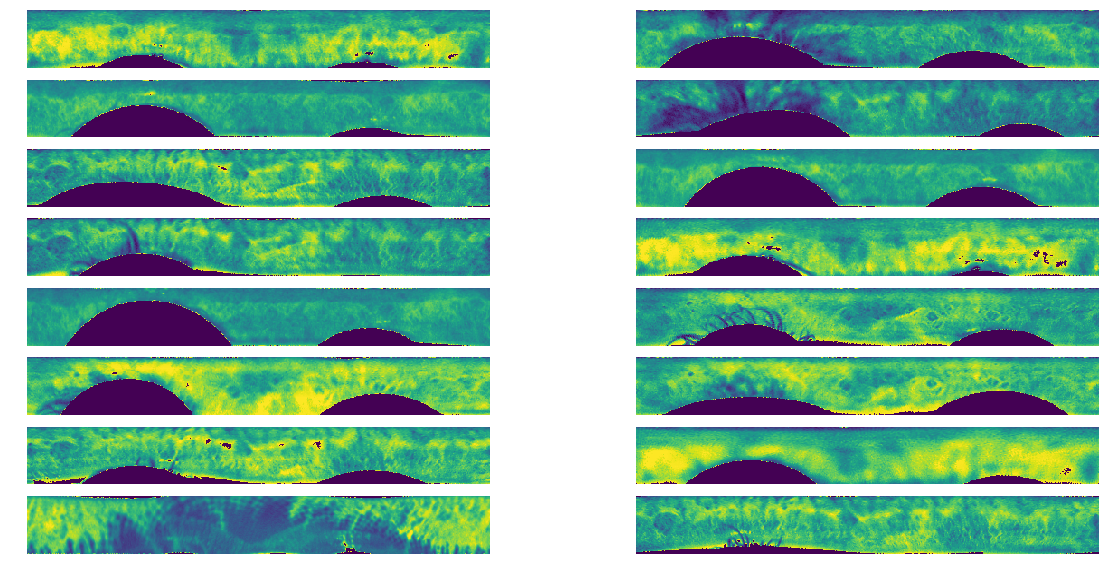

In [24]:
show_samples_from_tfr('../data/nd-iris-train-*.tfrecords')get_val_generator

In [6]:
input_img = Input(shape=(64, 512, 1))

x1 = Conv2D(16, (3, 7), activation='tanh', padding='same')(input_img)
x = AveragePooling2D((2, 2), padding='same')(x1)
x2 = Conv2D(24, (3, 5), activation='tanh', padding='same')(x)
x = AveragePooling2D((2, 2), padding='same')(x2)
x3 = Conv2D(32, (3, 3), activation='tanh', padding='same')(x)

x3 = UpSampling2D((4, 4))(x3)
x2 = UpSampling2D((2, 2))(x2)

x = Concatenate(axis=-1)([x3, x2, x1])

decoded = Conv2D(1, (3, 3), padding='same')(x)

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
get_train_generator = lambda: inputs(K.get_session(), '../data/nd-iris-train-*.tfrecords', 256, 50)
get_val_generator = lambda: inputs(K.get_session(), '../data/nd-iris-val-*.tfrecords', 256,50)

In [8]:
autoencoder.fit_generator(generator=get_train_generator(),
                epochs=50,
                steps_per_epoch=399, # batch size 256
                validation_data=get_val_generator(),
                validation_steps=85,
                workers = 0,
                use_multiprocessing=True,
                callbacks=[TensorBoard(log_dir='./iris_ae/4', write_images=True)])

Epoch 1/100
399/399 [==============================] - 192s 481ms/step - loss: 18.6234 - val_loss: 11.4626
Epoch 2/100
399/399 [==============================] - 187s 470ms/step - loss: 10.7336 - val_loss: 14.5498
Epoch 3/100
399/399 [==============================] - 187s 470ms/step - loss: 11.8972 - val_loss: 19.8234
Epoch 4/100
399/399 [==============================] - 187s 470ms/step - loss: 16.9095 - val_loss: 9.1389
Epoch 5/100
399/399 [==============================] - 187s 470ms/step - loss: 7.0278 - val_loss: 4.2240
Epoch 6/100
399/399 [==============================] - 188s 470ms/step - loss: 3.7027 - val_loss: 2.3460
Epoch 7/100
399/399 [==============================] - 188s 470ms/step - loss: 2.0699 - val_loss: 1.2758
Epoch 8/100
399/399 [==============================] - 188s 470ms/step - loss: 1.1558 - val_loss: 0.7315
Epoch 9/100
399/399 [==============================] - 188s 470ms/step - loss: 0.7317 - val_loss: 0.4287
Epoch 10/100
399/399 [==========================

KeyboardInterrupt: 

In [9]:
autoencoder.save('./iris_ae/4/model.hd5')

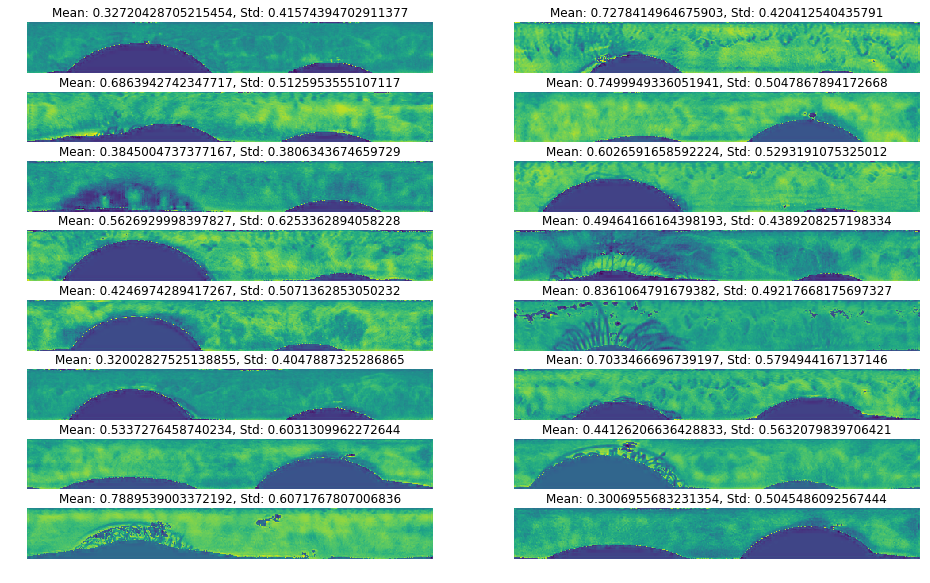

In [20]:
decoded_imgs = autoencoder.predict_generator(get_val_generator(), 1, workers=0)

n = 16
plt.figure(figsize=(15, 10))
start_index = np.random.randint(1, 128)

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(16, 10))
for i in range(start_index, start_index + n):
    # display reconstruction
    row = (i - start_index) // 2
    col = (i - start_index) % 2
    axes[row, col].axis("off")
    axes[row, col].imshow(decoded_imgs[i].reshape(64, 512))
    axes[row, col].set_title("Mean: {}, Std: {}".format(decoded_imgs[i].mean(), decoded_imgs[i].std()))